# The Image Registration Problem

Image registration is a core issue that is applicable across a wide range of contexts. For example, image registration is necessary when:

- Aligning fMRI volumes to correct for motion.
- Aligning longitudinal datasets together to assess change over time.
- Aligning data from different scanners and different sites in multi-centre research.
- Aligning data with a template or atlas to localise results and make comparisons across studies.

For all these cases, we can break the problem down into registering *two* images. This is our general framework for registration, where the goal is to move one image to align with the other. The image we move is known as the *source* image and the image we keep stationary is known as the *target* or *reference* image. 

## Motivation for Registration
To motivate the need for registration, consider the scans shown below. Clearly these images are not aligned because the anatomy of the brain does not overlap. As such, our broad aim would be to move one of the images until the anatomy is overlapping, at which point we would say that the images are *aligned* or are *registered*.

<iframe src="misaligned.html" width="800" height="600" frameborder="0" scrolling="no" title=""></iframe>

To understand why this is necessary consider that our aim is often to collate meaningful information across multiple images. In order to do this, we need some sort of *mapping* between the points in one image and the points in the other. If the images are identical in size, this is simply an identity mapping where we use the same coordinates for the two images. This will be the case if the images are generated from the same scanning sequence, or if one image has been *interpolated* to the dimensions of the other image. Alternatively, we can map between the images using world-space and the matrix $\mathbf{Q}$, as we explored last week. Either way, we take the coordinates in one image and transform them into coordinates in the other image in order to extract the matching voxel values.

```{important}
The most important point to realise is that just because a mapping exists, it does not mean that it is useful. For instance, mapping between two images is largely useless if the anatomy of the brain is not in the same position within each image. This is because the coordinates that are matched across the images are associated with *different* anatomical locations. Indeed, locations *inside* the brain in one image may be mapped to locations *outside* the brain in the other image. As such, there is an additional need, beyond simply mapping coordinates, for images to be *aligned*.
```

## `MATLAB` Example
To see the need for registration in context, consider reading the following two images into `MATLAB`

In [5]:
anat = spm_data_read('sub-01_T1w.nii');
func = spm_data_read('sub-01_task-flanker_run-1_bold.nii,1');

You can downloaded the [anatomical image]() and the [functional image]() yourself, if you want to follow along.

Now, consider an example situation where we are interested in voxel $[87,182,127]$ from the anatomical image. For instance, we may have already identified this as part of the anterior cingulate which is of interest in this study. We can extract the measured value from the anatomical image easily

In [7]:
anat(87,182,127)

ans = 210

However, for the functional file we hit a problem

In [9]:
func(87,182,127)

Index in position 1 exceeds array bounds. Index must not exceed 64.

This is because the functional data is much *smaller* than the anatomical data, which we can see by querying the dimensions in `MATLAB`

In [11]:
size(anat)
size(func)

ans = 1×3 double
   176   256   256

ans = 1×3 double
    64    64    40

We can see the issue if we try to draw these images on top of each other.

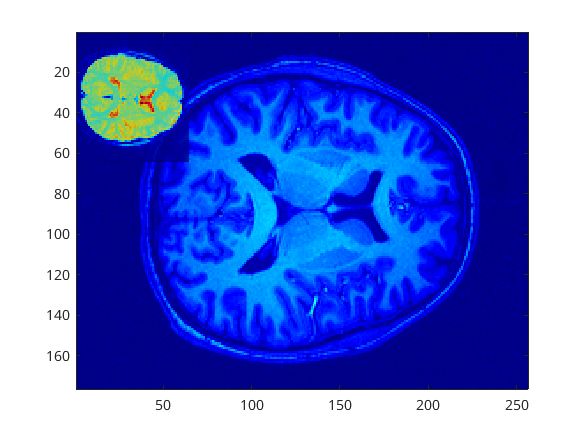

In [45]:
figure;
imagesc(anat(:,:,127)); 
hold on; 
imagesc(func(:,:,20),'AlphaData',0.8);
colormap jet;

Clearly, the functional image needs scaling in order to match the dimensions of the anatomical image. This requires some form of *interpolation*, which we can achieve using the `spm_reslice()` function. You will not need to call this from code usually, but you can see how to do it below.

In [15]:
files = {'sub-01_T1w.nii','sub-01_task-flanker_run-1_bold.nii,1'};
flags = spm_get_defaults('realign.write');
flags.which  = 1; % Just resample the functional image
flags.interp = 0; % Nearest-neighbour
spm_reslice(files,flags);


SPM12: spm_reslice (v7141)                         15:57:20 - 16/10/2024
Completed                               :          15:57:22 - 16/10/2024


If we now read in the interpolated functional data, we can see that both images are now the same size.

In [17]:
ifunc = spm_data_read('rsub-01_task-flanker_run-1_bold.nii,1');
size(anat)
size(ifunc)

ans = 1×3 double
   176   256   256

ans = 1×3 double
   176   256   256

Which means we can now extract the matching data from the functional image

In [19]:
ifunc(87,182,127)

ans = 6

However, just because we have managed to create a mapping between these two images (by resampling the functional to same dimensions as the anatomical) does not immediately mean that the same locations will align. We can see this if we now overlay the two images again

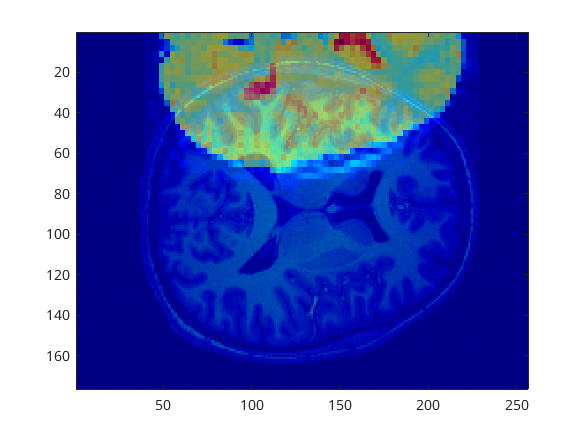

In [49]:
figure;
imagesc(anat(:,:,127)); 
hold on; 
imagesc(ifunc(:,:,127),'AlphaData',0.6);
colormap jet;

So even though we solved the initial problem of different image dimensions, because the images are not registered, simply resampling one image into the space of the other does not automatically cause the anatomy to align. The result for this example is that voxel $[87,182,127]$ corresponds to the anterior cingulate in the anatomical image, but is actually *outside the brain* in the functional image. In order to resolve this, we need to *register* the images first. How we do that is the topic of this lesson.